In [1]:
import numpy as np
import pandas as pd
from subprocess import check_output
from sklearn import ensemble, metrics, linear_model
import random
%matplotlib inline

In [2]:
rnd=191989
random.seed(rnd)
n_ft=15 #Number of features to add
max_elts=5

In [3]:
class addNearestNeighbourLinearFeatures:
    
    def __init__(self, n_neighbours=1, max_elts=None, verbose=True, random_state=None):
        self.rnd = random_state
        self.n = n_neighbours
        self.max_elts = max_elts
        self.verbose = verbose
        self.neighbours = []
        self.clfs = []
        
    def fit(self, train, y):
        if self.rnd != None:
            random.seed(rnd)
        if self.max_elts == None:
            self.max_elts = len(train.columns)
        list_vars = list(train.columns)
        random.shuffle(list_vars)
        
        lastscores = np.zeros(self.n) + 1e15

        for elt in list_vars[:self.n]:
            self.neighbours.append([elt])
        list_vars = list_vars[self.n:]
        
        for elt in list_vars:
            indice = 0
            scores = []
            for elt2 in self.neighbours:
                if len(elt2) < self.max_elts:
                    clf = linear_model.LinearRegression(fit_intercept=False, 
                                                        normalize=True, copy_X=True) 
                    clf.fit(train[elt2+[elt]], y)
                    scores.append(metrics.log_loss(y,clf.predict(train[elt2 + [elt]])))
                    indice=indice+1
                else:
                    scores.append(lastscores[indice])
                    indice=indice+1
            gains = lastscores - scores
            if gains.max() > 0:
                temp = gains.argmax()
                lastscores[temp] = scores[temp]
                self.neighbours[temp].append(elt)

        indice = 0
        for elt in self.neighbours:
            clf = linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True) 
            clf.fit(train[elt], y)
            self.clfs.append(clf)
            if self.verbose:
                print(indice, lastscores[indice], elt)
            indice = indice + 1
                    
    def transform(self, train):
        indice = 0
        for elt in self.neighbours:
            train['_'.join(pd.Series(elt).sort_values().values)] = self.clfs[indice].predict(train[elt])
            indice = indice + 1
        return train
    
    def fit_transform(self, train, y):
        self.fit(train, y)
        return self.transform(train)

In [4]:
train = pd.read_csv("data/train.csv")
target = train['target'].values
test = pd.read_csv("data/test.csv")
id_test = test['ID'].values

In [5]:
train['v22-1']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
test['v22-1']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
train['v22-2']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
test['v22-2']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
train['v22-3']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
test['v22-3']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
train['v22-4']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))
test['v22-4']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))

drop_list=['v91','v1', 'v8', 'v10', 'v15', 'v17', 'v25', 'v29', 
           'v34', 'v41', 'v46', 'v54', 'v64', 'v67', 'v97', 'v105', 'v111', 'v122']
train = train.drop(['ID','target'] + drop_list,axis=1).fillna(-999)
test = test.drop(['ID'] + drop_list,axis=1).fillna(-999)

refcols=list(train.columns)

In [6]:
for elt in refcols:
    if train[elt].dtype=='O':
        train[elt], temp = pd.factorize(train[elt])
        test[elt]=temp.get_indexer(test[elt])
    else:
        #train[train[elt] == 20] = -999
        #test[test[elt] == 20] = -999
        train[elt]=train[elt].round(5)
        test[elt]=test[elt].round(5)

In [7]:
a=addNearestNeighbourLinearFeatures(n_neighbours=n_ft, max_elts=max_elts, verbose=True, random_state=rnd)
a.fit(train, target)

train = a.transform(train)
test = a.transform(test)

0 0.857936296658 ['v9', 'v126', 'v45', 'v55', 'v21']
1 0.560635902021 ['v53', 'v57', 'v43', 'v89', 'v2']
2 0.60592220067 ['v114', 'v84', 'v101', 'v61', 'v93']
3 1.19645086749 ['v112', 'v123', 'v51', 'v102', 'v62']
4 0.722759106994 ['v13', 'v86', 'v27', 'v18', 'v85']
5 0.564896139836 ['v130', 'v19', 'v69', 'v127', 'v22-3']
6 0.731445183697 ['v81', 'v124', 'v36', 'v82', 'v48']
7 1.10498487505 ['v24', 'v107', 'v28', 'v52', 'v20']
8 0.594309329043 ['v37', 'v73', 'v65', 'v76', 'v90']
9 0.601229963483 ['v88', 'v96', 'v3', 'v38', 'v42']
10 1.40705040933 ['v22', 'v50', 'v92', 'v59', 'v58']
11 0.561642727643 ['v117', 'v12', 'v109', 'v113', 'v22-4']
12 0.660709937507 ['v33', 'v106', 'v77', 'v7', 'v32']
13 2.03335775613 ['v71', 'v80', 'v31', 'v60', 'v6']
14 1.74028555247 ['v119', 'v74', 'v125', 'v98', 'v16']


In [8]:
from libtelepot import sendMessage

In [9]:
preds = list()
mf = 55
md = 35
for rnd in range(12, 40):
    print(rnd, md, mf, flush=True)
    sendMessage('Hey, I\'m running your shitty script with seed = {:}, you lazy fucker'.format(rnd))
    clf = ensemble.ExtraTreesClassifier(n_estimators=3750, max_features=mf ,criterion='entropy',
                                        min_samples_split=4, max_depth=md, min_samples_leaf=2, 
                                        n_jobs = -1, random_state=rnd)
    clf.fit(train,target)
    pred_et = clf.predict_proba(test)[:, 1]
    preds.append(pred_et)

12 35 55
13 35 55
14 35 55
15 35 55
16 35 55
17 35 55
18 35 55
19 35 55
20 35 55
21 35 55
22 35 55
23 35 55


KeyboardInterrupt: 

In [12]:
np.array(preds).mean(axis=0).shape

(114393,)

In [10]:
import pickle

In [11]:
with open('keksec.pkl', 'wb') as f:
    pickle.dump(np.array(preds), f, protocol=2)

In [12]:
with open('kek.pkl', 'rb') as f:
    myold = pickle.load(f)

In [28]:
my = np.vstack((myold, np.array(preds)))

In [24]:
sv = pd.read_csv('woe_mean_pred.csv')

In [27]:
sv = sv.PredictedProb.values

In [30]:
my.mean(axis=0).shape, sv.shape

((114393,), (114393,))

In [33]:
finz = .68*my.mean(axis=0) + .32*sv

In [35]:
finz, my.mean(axis=0), sv

(array([ 0.38134411,  0.83253723,  0.83865838, ...,  0.92172533,
         0.9408101 ,  0.5580156 ]),
 array([ 0.36067409,  0.83439408,  0.81989932, ...,  0.91925303,
         0.93622129,  0.55447438]),
 array([ 0.42526789,  0.82859142,  0.87852137, ...,  0.92697898,
         0.95056131,  0.56554069]))

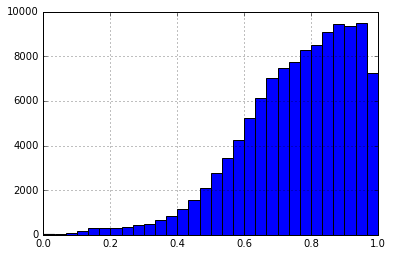

In [36]:
submission=pd.read_csv('data/sample_submission.csv')
submission.index=submission.ID
submission.PredictedProb=finz
submission.to_csv('submission/finz.csv', index=False)
submission.PredictedProb.hist(bins=30)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

 # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

from sklearn import ensemble, metrics, linear_model
import random

#Some parameters to play with
rnd=12
random.seed(rnd)
n_ft=20 #Number of features to add
max_elts=3 #Maximum size of a group of linear features

class addNearestNeighbourLinearFeatures:
    
    def __init__(self, n_neighbours=1, max_elts=None, verbose=True, random_state=None):
        self.rnd=random_state
        self.n=n_neighbours
        self.max_elts=max_elts
        self.verbose=verbose
        self.neighbours=[]
        self.clfs=[]
        
    def fit(self,train,y):
        if self.rnd!=None:
            random.seed(rnd)
        if self.max_elts==None:
            self.max_elts=len(train.columns)
        list_vars=list(train.columns)
        random.shuffle(list_vars)
        
        lastscores=np.zeros(self.n)+1e15

        for elt in list_vars[:self.n]:
            self.neighbours.append([elt])
        list_vars=list_vars[self.n:]
        
        for elt in list_vars:
            indice=0
            scores=[]
            for elt2 in self.neighbours:
                if len(elt2)<self.max_elts:
                    clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
                    clf.fit(train[elt2+[elt]], y)
                    scores.append(metrics.log_loss(y,clf.predict(train[elt2 + [elt]])))
                    indice=indice+1
                else:
                    scores.append(lastscores[indice])
                    indice=indice+1
            gains=lastscores-scores
            if gains.max()>0:
                temp=gains.argmax()
                lastscores[temp]=scores[temp]
                self.neighbours[temp].append(elt)

        indice=0
        for elt in self.neighbours:
            clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
            clf.fit(train[elt], y)
            self.clfs.append(clf)
            if self.verbose:
                print(indice, lastscores[indice], elt)
            indice=indice+1
                    
    def transform(self, train):
        indice=0
        for elt in self.neighbours:
            train['_'.join(pd.Series(elt).sort_values().values)]=self.clfs[indice].predict(train[elt])
            indice=indice+1
        return train
    
    def fit_transform(self, train, y):
        self.fit(train, y)
        return self.transform(train)
    
    
train = pd.read_csv("../input/train.csv")
target = train['target'].values
test = pd.read_csv("../input/test.csv")
id_test = test['ID'].values

train['v22-1']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
test['v22-1']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
train['v22-2']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
test['v22-2']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
train['v22-3']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
test['v22-3']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
train['v22-4']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))
test['v22-4']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))

drop_list=['v91','v1', 'v8', 'v10', 'v15', 'v17', 'v25', 'v29', 'v34', 'v41', 'v46', 'v54', 'v64', 'v67', 'v97', 'v105', 'v111', 'v122']
train = train.drop(['ID','target'] + drop_list,axis=1).fillna(-999)
test = test.drop(['ID'] + drop_list,axis=1).fillna(-999)

refcols=list(train.columns)

for elt in refcols:
    if train[elt].dtype=='O':
        train[elt], temp = pd.factorize(train[elt])
        test[elt]=temp.get_indexer(test[elt])
    else:
        train[elt]=train[elt].round(5)
        test[elt]=test[elt].round(5)
        
a=addNearestNeighbourLinearFeatures(n_neighbours=n_ft, max_elts=max_elts, verbose=True, random_state=rnd)
a.fit(train, target)

train = a.transform(train)
test = a.transform(test)

clf = ensemble.ExtraTreesClassifier(n_estimators=750,max_features=50,criterion= 'entropy',min_samples_split= 4,
                        max_depth= 35, min_samples_leaf= 2, n_jobs = -1, random_state=rnd)

clf.fit(train,target)
pred_et=clf.predict_proba(test)

submission=pd.read_csv('../input/sample_submission.csv')
submission.index=submission.ID
submission.PredictedProb=pred_et[:,1]
submission.to_csv('./addNNLinearFt.csv', index=False)
submission.PredictedProb.hist(bins=30)